In [5]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.3 MB/s eta 0:0

In [6]:
import os

import numpy as np
import pandas as pd

import datasets
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Caricamento dataset

In [8]:
df_train = pd.read_csv('haspeede_FB-train.tsv', sep='\t', header=None, names=['id', 'text', 'label'], index_col='id',)
df_train.head()

,text,label
id,,
1,Io voterò no😍😍😍Renzi deve andare a casa😢😢😢,0
2,Poi si sentono fiere eh😂,0
3,Belli,0
4,Arrusi,0
5,"sono indigeste, fanno anche venire la colica i...",1


In [9]:
df_test = pd.read_csv('haspeede_FB-reference.tsv', sep='\t', header=None, names=['id', 'text', 'label'], index_col='id',)
df_test.head()

,text,label
id,,
1,Ma....anche no!,0
2,Ma dove vivono ?,0
3,Le vai a impollinare tu le piante e gli alberi...,0
4,Ma manda li a quel paese questi zingari bugiardi,1
5,"Complimenti a chi sostiene ancora questa ""poli...",1


In [10]:
df_train.shape

(3000, 2)

In [11]:
df_test.shape

(1000, 2)

In [12]:
df_train.label.unique() # array delle label

array([0, 1])

# Caricamento del modello

Carichiamo il modello tramite la libreria *transformers* di Huggingface.

In [20]:
model_name = 'dbmdz/bert-base-italian-cased'
# Carico il modello
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

# Preprocessing dei dati

I dati vengono prima convertiti nel formato *datasets* e poi il dataset di training viene ulteriormente diviso in *train* e *validation* set.

In [21]:
# Conversione da lista di dizionari a dataset
train = datasets.Dataset.from_pandas(df_train)
test = datasets.Dataset.from_pandas(df_test)

In [22]:
train

Dataset({
    features: ['text', 'label', 'id'],
    num_rows: 3000
})

Dividiamo il dataset di addestramento, usando il 20% per fare validation.

In [23]:
splitting = train.train_test_split(test_size=0.2, seed=42)

In [24]:
splitting

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'id'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['text', 'label', 'id'],
        num_rows: 600
    })
})

In [25]:
train = splitting["train"]
validation = splitting["test"]

# Shape dei dati di train, dev e test
print("Train:", train.shape)
print("Validation:", validation.shape)
print("Test:", test.shape)

Train: (2400, 3)
Validation: (600, 3)
Test: (1000, 3)


## Tokenizzazione

In [26]:
# Funzione che applica la tokenizzazione ai dati di training, validation e test
def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True)
    return tokens

train = train.map(tokenize, batched=True)
validation = validation.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
validation.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Addestramento del modello

Abbiamo bisogno di definire:
- *Training Arguments*: gli argomenti di addestramento (e.g. numero di epoche/step, learning rate, batch_size, logging/saving strategy, etc.);
- *Metrica*: metrica di addestramento, per valutare le performance del modello in fase di evaluation;
- *Trainer*: oggetto della libreria *Transformers* che processa tutti gli argomenti e, tramite il metodo *.train()* fa partire l'addestramento.

## Metrica

In [28]:
def compute_metrics(eval_pred):
  '''Prende in input le predizioni del modello, applica loro un argmax e calcola l'F1 score tra le predizioni e le
  etichette reali'''
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

## Training Arguments

In [30]:
training_args = TrainingArguments(
        f"{model_name}-finetuned",
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        logging_steps=10,
        learning_rate=2e-5,
        per_device_train_batch_size=25,
        per_device_eval_batch_size=25,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True)

In [31]:
trainer = Trainer(
      model,
      training_args,
      train_dataset=train,
      eval_dataset=validation,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics)
trainer.train()
log_history = trainer.state.log_history

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.519700,0.357798,0.836761
2,0.326100,0.320222,0.857678
3,0.209400,0.345106,0.866416
4,0.137300,0.387757,0.859737
5,0.103000,0.408772,0.863028


# Valutazione del modello

In [34]:
pred_results = trainer.predict(validation)

In [35]:
y_val_pred = np.argmax(pred_results.predictions, axis=1)

In [36]:
y_val = validation['label'].tolist()

In [37]:
report = classification_report(y_val, y_val_pred)

In [38]:
print(report)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       317
           1       0.89      0.80      0.84       283

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



## Monitoraggio della loss

In [39]:
log_history = trainer.state.log_history

<ipython-input-40-90e86fccba69>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-40-90e86fccba69>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-40-90e86fccba69>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-40-90e86fccba69>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

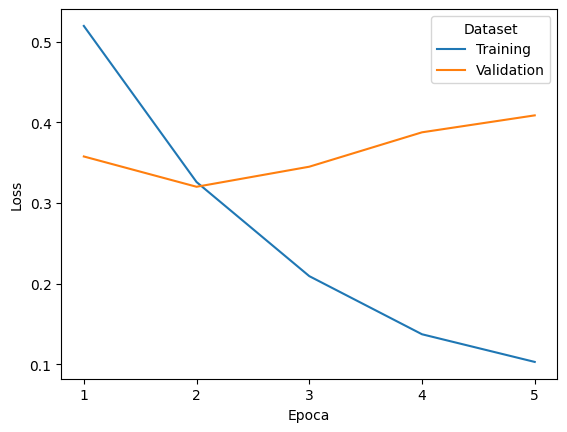

In [40]:
# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history: # cicla sulla lista di dizionari
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 6))
plt.xlabel('Epoca')
plt.savefig('loss_curves.pdf', dpi=300, bbox_inches='tight')

# Calcolo performance sul test set

In [42]:
output_predictions = trainer.predict(test)

In [43]:
output_predictions.predictions

array([[ 2.085016  , -1.9020729 ],
       [ 0.97753114, -1.0716221 ],
       [ 0.00391712, -0.0728303 ],
       ...,
       [-1.5899978 ,  1.4720387 ],
       [ 0.56054366, -0.93303376],
       [-1.378757  ,  1.3007883 ]], dtype=float32)

In [44]:
y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)

In [45]:
print(report)

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       323
           1       0.88      0.88      0.88       677

    accuracy                           0.84      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.84      0.84      0.84      1000



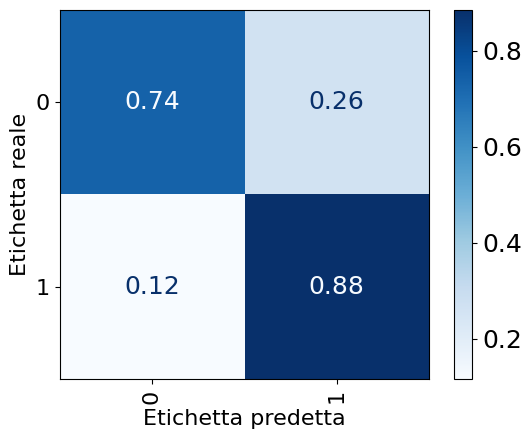

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig('conf_matrix_transformer.pdf', dpi=300, bbox_inches='tight')
plt.show()